In [477]:
import requests
import time
import os
import re
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.firefox import options as firefox_options
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt 
import seaborn as sns
import streamlit as st
url='https://www.vikings-auto.fr/voiture?action=liste&parc%5B%5D=1&parc%5B%5D=2&gad_source=1&gclid=CjwKCAiA_tuuBhAUEiwAvxkgToP4NCKhDpYmRfFyrXNaCtHOep0RjNQPV0K6gaaRE5fa5eqpEASJUxoCmS8QAvD_BwE&entrant=1'

response=requests.get(url)
print(response)

<Response [200]>


In [478]:
if response.ok:
    soup=BeautifulSoup(response.text,'lxml')
    bodies=soup.findAll('body')
    [print(str(body)+'\n\n') for body in bodies]

<body class="cachemenu">
<div itemscope="" itemtype="https://schema.org/WebSite">
<meta content="https://www.vikings-auto.fr" itemprop="url"/>
<meta content="Vikings Auto" itemprop="name"/>
</div>
<header class="menu-1-ligne" id="haut">
<div class="centre">
<a href="/index.php" id="logo"></a>
<a href="tel:0258151515" id="contact" onclick="return gtag_report_conversion('tel:0258151515');"><img src="/images/icone-tel-bleu.png"/><span>02 58 15 15 15</span></a>
<div class="menu">
<ul class="nav">
<li class=""><a class="" href="/voiture?parc[]=3" target="_self">Neuf</a>
<ul class="ssmenu">
<li>
<div id="marque">
<p class="titre">Marques</p>
<p><a href="/voiture/audi-neuf">AUDI</a></p>
<p><a href="/voiture/cupra-neuf">CUPRA</a></p>
<p><a href="/voiture/seat-neuf">SEAT</a></p>
<p><a href="/voiture/skoda-neuf">SKODA</a></p>
<p><a href="/voiture/suzuki-neuf">SUZUKI</a></p>
<p><a href="/voiture/volkswagen-neuf">VOLKSWAGEN</a></p>
<p><a href="/voiture/volkswagen-utilitaires-neuf">VOLKSWAGEN UTILI

In [479]:
def get_page(count=1):
    driver=webdriver.Firefox()
    pages=[]
    for page_nb in range(1,count+1):
        page_url=f'https://www.vikings-auto.fr/voiture?action=liste&parc%5B%5D=1&parc%5B%5D=2&gad_source=1&gclid=CjwKCAiA_tuuBhAUEiwAvxkgToP4NCKhDpYmRfFyrXNaCtHOep0RjNQPV0K6gaaRE5fa5eqpEASJUxoCmS8QAvD_BwE&entrant={page_nb}'
        driver.get(page_url)
        time.sleep(10)
        pages.append(driver.page_source.encode("utf-8"))
    return pages

def save_pages(pages):
    os.makedirs("data",exist_ok=True)
    for page_nb,page in enumerate(pages):
        with open(f"data/page_{page_nb}.html","wb") as f_out:
            f_out.write(page)
            
def parse_pages():
    pages_paths=os.listdir("data")
  
    results=pd.DataFrame()
    for page_path in pages_paths:
        with open("data/"+page_path,"r") as f_in:
            page=f_in.read()
            result=parse_page(page)
            results = pd.concat([results, result])
    return results

def clean_prix(tag):
    text=tag.text.strip()
    prix=int(text.replace("€","").replace(" ",""))
    return prix


def clean_info_concession(tag):
    text=tag.text.strip()
    info=text.split(" ")
    return info[-1]


def clean_marque(tag):
    text=tag.text.strip()
    marque=text.split(" ")
    return marque[0]


def clean_vehiculeinfos(tag):
    text=tag.text.strip()
    liste=text.replace(" ","").split("/")
    liste[1]=liste[1].replace("km","")
    
    return liste


def parse_page(page):
    result=pd.DataFrame()
    soup=BeautifulSoup(page,"html.parser")
    nom=soup.find_all(attrs={"class":"nom"})
    info=soup.find_all(attrs={"class":"info"})
    v_info=soup.find_all(attrs={"class":"vehiculeinfos"})
    ville=soup.find_all(attrs={"class":"info concession"})
    prix=soup.find_all(attrs={"class":"prix"})
    result["marque"]=[clean_marque(tag) for tag in nom]
    result["info"] = [tag.text.strip() for tag in info[::2]]
    result["type_carburant"]=[clean_vehiculeinfos(tag)[-1] for tag in v_info]
    result["kilometrage"]=[clean_vehiculeinfos(tag)[1] for tag in v_info]
    result["annee"]=[clean_vehiculeinfos(tag)[0] for tag in v_info]
    
    result["prix"]=[clean_prix(tag) for tag in prix]
    
    
    return result



    

In [480]:

#pages=get_page(count=10)
#save_pages(pages)
resultats=parse_pages()


In [481]:
resultats.head()

,marque,info,type_carburant,kilometrage,annee,prix
0,FORD,Kuga 1.5 Flexifuel-E85 150 S&S 4x2 BVA6 Titanium,Diesel,19423,2019,20990
1,SKODA,Kamiq 1.6 TDI 116 ch DSG7 Business,Diesel,63888,2020,21230
2,VOLKSWAGEN,Polo 1.0 TSI 95 S&S BVM5 Style,Essence,20764,2023,21290
3,SEAT,Ateca 2.0 TDI 150 ch Start/Stop DSG7 Xcellence,Diesel,118195,2019,21390
4,VOLKSWAGEN,T-Cross 1.0 TSI 110 Start/Stop DSG7 R-Line,Essence,65480,2021,21490


In [482]:
resultats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 918 entries, 0 to 97
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   marque          918 non-null    object
 1   info            918 non-null    object
 2   type_carburant  918 non-null    object
 3   kilometrage     918 non-null    object
 4   annee           918 non-null    object
 5   prix            918 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 50.2+ KB


In [483]:
resultats.shape

(918, 6)

In [484]:
resultats.reset_index(drop=True, inplace=True)

In [485]:
resultats['kilometrage'].unique()

array(['19423', '63888', '20764', '118195', '65480', '16272', '5000',
       '4800', '15490', '74827', '93388', '60770', '9097', '3900',
       '85849', '53756', '32928', '8000', '37875', '41400', '46390',
       '32174', '13206', '6950', '48450', '35709', '15016', '4998',
       '4766', '103811', '89656', '45652', '10747', '57902', '135201',
       '57376', '24814', '9973', '16620', '20310', '36500', '10314',
       '24288', '24000', '20103', '82076', '30445', '39865', '23431',
       '38642', '4281', '15639', '19649', '59113', '34234', '8052',
       '10204', '11548', '10245', '17012', '13180', '38827', '61850',
       '88553', '11711', '27000', '82988', '6412', '14022', '10000',
       '85328', '8400', '14858', '42511', '13135', '12392', '98087',
       '86553', '14294', '18102', '20709', '5719', '22031', '18758',
       '10010', '10347', '6192', '44218', '17033', '8150', '11181',
       '32285', '79335', '85976', '15046', '22187', '11171', '15360',
       '73962', '96931', '63256',

In [486]:
resultats['annee'].unique()

array(['2019', '2020', '2023', '2021', '2022', '2017', '', '2016', '2018',
       '2011', '2012', '2015', '2024'], dtype=object)

In [487]:
condition = resultats['kilometrage']=='Diesel'
condition2= resultats['kilometrage']=='CourantElectrique'

condition3= resultats['kilometrage']=='Essence'
condition4 = resultats['annee']==''

donnees_filtrees=resultats[condition | condition2 | condition3 |condition4]
donnees_filtrees.head()

,marque,info,type_carburant,kilometrage,annee,prix
12,VOLKSWAGEN,T-Cross 1.0 TSI 110 Start/Stop BVM6 Lounge,Essence,9097,,21750
196,VOLKSWAGEN,Tiguan 2.0 TDI 150ch DSG7 MATCH,Diesel,2500,,44990
203,AUDI,A3 Sportback 35 TDI 150 S tronic 7 S Line,Diesel,9900,,45500
204,VOLKSWAGEN,ID.5 204 ch Pro Performance CLASSIQUE,CourantElectrique,10000,,45580
209,VOLKSWAGEN,Tiguan 1.4 eHybrid 245ch DSG6 Life Plus,CourantElectrique,Essence,2023,45990


In [488]:
donnees_filtrees.shape

(79, 6)

In [489]:
# Obtenir les indices des lignes qui satisfont les conditions
indices_a_supprimer = resultats[condition | condition2 | condition3|condition4].index

# Supprimer les lignes correspondantes du DataFrame
resultats = resultats.drop(indices_a_supprimer)

# Afficher le résultat
resultats.head()


,marque,info,type_carburant,kilometrage,annee,prix
0,FORD,Kuga 1.5 Flexifuel-E85 150 S&S 4x2 BVA6 Titanium,Diesel,19423,2019,20990
1,SKODA,Kamiq 1.6 TDI 116 ch DSG7 Business,Diesel,63888,2020,21230
2,VOLKSWAGEN,Polo 1.0 TSI 95 S&S BVM5 Style,Essence,20764,2023,21290
3,SEAT,Ateca 2.0 TDI 150 ch Start/Stop DSG7 Xcellence,Diesel,118195,2019,21390
4,VOLKSWAGEN,T-Cross 1.0 TSI 110 Start/Stop DSG7 R-Line,Essence,65480,2021,21490


In [490]:
resultats.shape

(839, 6)

In [491]:
resultats['kilometrage'].unique()

array(['19423', '63888', '20764', '118195', '65480', '16272', '5000',
       '4800', '15490', '74827', '93388', '60770', '3900', '85849',
       '53756', '32928', '8000', '37875', '41400', '46390', '32174',
       '13206', '6950', '48450', '35709', '15016', '4998', '4766',
       '103811', '89656', '45652', '10747', '57902', '135201', '57376',
       '24814', '9973', '16620', '20310', '36500', '10314', '24288',
       '24000', '20103', '82076', '30445', '39865', '23431', '38642',
       '4281', '15639', '19649', '59113', '34234', '8052', '10204',
       '11548', '10245', '17012', '13180', '38827', '61850', '88553',
       '11711', '27000', '82988', '6412', '14022', '10000', '85328',
       '8400', '14858', '42511', '13135', '12392', '98087', '86553',
       '14294', '18102', '20709', '5719', '22031', '18758', '10010',
       '10347', '6192', '44218', '17033', '8150', '11181', '32285',
       '79335', '85976', '15046', '22187', '11171', '15360', '73962',
       '96931', '63256', '76022'

In [492]:
resultats['annee'].unique()

array(['2019', '2020', '2023', '2021', '2022', '2017', '2016', '2018',
       '2011', '2012', '2015', '2024'], dtype=object)

In [493]:
resultats['kilometrage'] = resultats['kilometrage'].astype(int)
resultats['annee'] = resultats['annee'].astype(int)

In [494]:
resultats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 839 entries, 0 to 917
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   marque          839 non-null    object
 1   info            839 non-null    object
 2   type_carburant  839 non-null    object
 3   kilometrage     839 non-null    int64 
 4   annee           839 non-null    int64 
 5   prix            839 non-null    int64 
dtypes: int64(3), object(3)
memory usage: 45.9+ KB


In [495]:
label_encoder = LabelEncoder()

# Boucler à travers chaque colonne du dataset
for column in resultats.columns:
    # Vérifier si la colonne contient des données catégoriques (type 'object')
    if resultats[column].dtype == 'object':
        # Appliquer le LabelEncoder à la colonne catégorique
        resultats[column] = label_encoder.fit_transform(resultats[column])

In [496]:
resultats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 839 entries, 0 to 917
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   marque          839 non-null    int64
 1   info            839 non-null    int64
 2   type_carburant  839 non-null    int64
 3   kilometrage     839 non-null    int64
 4   annee           839 non-null    int64
 5   prix            839 non-null    int64
dtypes: int64(6)
memory usage: 45.9 KB


In [497]:
resultats.head()

,marque,info,type_carburant,kilometrage,annee,prix
0,6,219,1,19423,2019,20990
1,18,210,1,63888,2020,21230
2,21,260,2,20764,2023,21290
3,17,85,1,118195,2019,21390
4,21,338,2,65480,2021,21490


/home/kencapoche/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/kencapoche/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


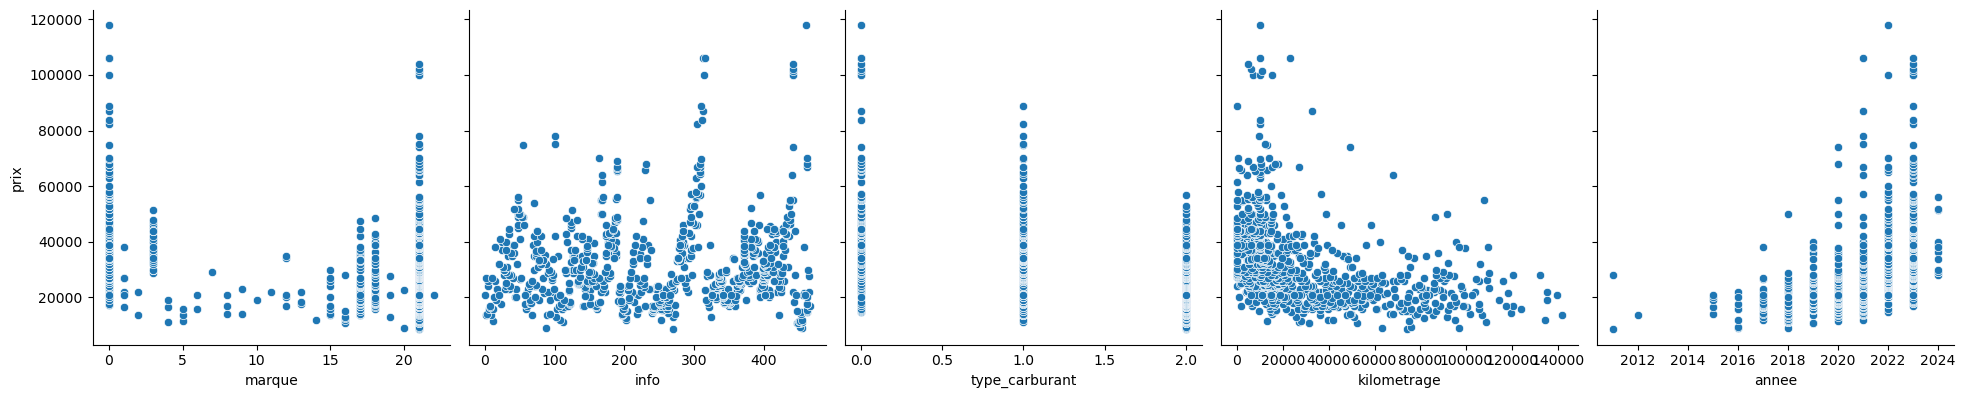

In [499]:
# Using pairplot we'll visualize the data for correlation
sns.pairplot(resultats, x_vars=['marque','info','type_carburant','kilometrage','annee'], 
             y_vars='prix', size=4, aspect=1, kind='scatter')
plt.show()

In [500]:
X = resultats[['marque','info','type_carburant','kilometrage','annee']]
y = resultats['prix']
print(X.shape)
print(y.shape)

(839, 5)
(839,)


In [511]:
scores=[]
for i in range (100000):
    X_train, X_test, y_train, y_test = train_test_split(X, y,train_size = 0.8,test_size = 0.2,random_state=i) 
    # Creating an object of Linear Regression
    lm = LinearRegression()

    # Fit the model using .fit() method
    lm.fit(X_train, y_train)
    y_test_pred = lm.predict(X_test)
    scores.append(r2_score(y_test,y_test_pred))

In [512]:
#X_test.head()

In [513]:
#y_test.head()

In [514]:
np.argmax(scores)

86680

In [515]:
scores[np.argmax(scores)]

0.7180819704538093

In [516]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8,test_size = 0.2,random_state=np.argmax(scores))
# Creating an object of Linear Regression
lm = LinearRegression()

# Fit the model using .fit() method
lm.fit(X_train, y_train)
y_test_pred = lm.predict(X_test)
r2_score(y_test,y_test_pred)

0.7180819704538093

In [517]:
import statsmodels.api as sm

# Ajoutez une colonne de constante à X_train
X_train_const = sm.add_constant(X_train)

# Créez un modèle OLS (Ordinary Least Squares)
model = sm.OLS(y_train, X_train_const)

# Ajustez le modèle aux données d'entraînement
result = model.fit()

# Affichez un résumé du modèle
print(result.summary())


                            OLS Regression Results                            
Dep. Variable:                   prix   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     135.3
Date:                Sun, 25 Feb 2024   Prob (F-statistic):           7.66e-99
Time:                        19:22:21   Log-Likelihood:                -7168.4
No. Observations:                 671   AIC:                         1.435e+04
Df Residuals:                     665   BIC:                         1.438e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -4.638e+06   6.86e+05     -6.

In [518]:
# Intercept value
#print("Intercept :",lm.intercept_)

# Slope value
#print('Slope :',lm.coef_)

In [519]:
# Making Predictions of y_value
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)

# Comparing the r2 value of both train and test data
print(r2_score(y_train,y_train_pred))
print(r2_score(y_test,y_test_pred))

0.5042785791410873
0.7180819704538093


In [520]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Créer un modèle de régression linéaire
model = LinearRegression()

# Effectuer la validation croisée avec 5 plis
scores = cross_val_score(model, X_train, y_train, cv=5)

# Afficher les scores de validation croisée
print("Scores de validation croisée:", scores)

# Afficher la moyenne des scores de validation croisée
print("Moyenne des scores de validation croisée:", scores.mean())


Scores de validation croisée: [0.50033766 0.53884486 0.50469704 0.4208726  0.52859394]
Moyenne des scores de validation croisée: 0.4986692191816947


In [510]:
resultats.to_csv("clean_data_car.csv", index=False)